In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as sps
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3, palette='Set2')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


# PyMC3

Библиотека PyMC3 написана поверх Theano и поэтому может быть использована вместе с ней.

## 1. Создание модели

Модель определяется с помощью класса `Model` внутри контекста `with` 

In [2]:
with pm.Model() as model:
    pass

Рассмотрим следующую модель:

$X = (X_1, ..., X_n) \sim \mathcal{N}(\mu, 1)$ --- выборка

$\mu \sim \mathcal{N}(0, 1)$ --- априорное распределение параметра

Зададим выборку:

In [3]:
sample = sps.norm.rvs(size=100)

Теперь определяем модель

In [4]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    X = pm.Normal('X', mu=mu, sigma=1, observed=sample)

В качестве `observed` поддерживаются списки `numpy.ndarray`, `theano` и `pandas` структуры.

Список всех случайных величин модели

In [5]:
model.basic_RVs

[mu, X]

Список ненаблюдаемых величин

In [6]:
model.free_RVs

[mu]

Список наблюдаемых величин

In [7]:
model.observed_RVs

[X]

Логарифм совместной плотности всех величин модели (в данном случае $(X, \mu)$):

In [8]:
model.logp({'mu': 0})

array(-139.83094784)

В данном случае вычисления произведены по формуле $\log p(x, t) = \log p_t(x) + \log q(t)$. Можем это проверить явно

In [9]:
sps.norm.logpdf(sample).sum() + sps.norm.logpdf(0)

-139.83094783709265

**Замечание.** `logp` похож на атрибут, хотя фактически его созданием занимается некоторая функция на основе текущего состояния модели. Это удобно для меняющихся моделей, но влечет проблемы по скорости работы при статических моделях, например, при использовании в цикле.

Среднее время работы функции:

In [10]:
%timeit model.logp({mu: 0.1})

53.7 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Вынесем атрибут в отдельную операцию и снова посчитаем время вычисления:

In [11]:
logp = model.logp
%timeit logp({mu: 0.1})

14.9 µs ± 108 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## 2. Распределения

Список всех вероятностных распределений
https://docs.pymc.io/api/distributions.html

Например, вот так можно задать нормальное распределение

In [12]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1)

Матрица 3x3 из независимых случайных величин, имеющих бета-распределение

In [13]:
with pm.Model():
    p = pm.Beta('p', 1, 1, shape=(3, 3))

Списки случайных величин тоже можно делать, но не рекомендуется

In [14]:
with pm.Model():
    x = [pm.Normal('x_{}'.format(i), mu=0, sigma=1) for i in range(10)] # bad

О том, как можно создать свое распределение, можно почитать тут https://docs.pymc.io/Probability_Distributions.html

Детерминированные операции над случайными величинами

In [15]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1)
    y = pm.Gamma('y', alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

Результаты таких операций не сохраняются автоматически. Чтобы их отслеживать, стоит использовать `pm.Deterministic`:

In [16]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1)
    plus_2 = pm.Deterministic('x plus 2', x + 2)

Чтобы сделать семплирование более эффективным, ограниченные случайные величины преобразуются в неограниченные

In [17]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1)
    
model.free_RVs

[x_interval__]

Величина `x_interval__` представляет преобразованный `x` на интервал $(-\infty, +\infty)$. В данном случае применено `LogOdd`-преобразования, поскольку есть верхняя и нижняя границы. Исходные не преобразованные параметры тоже отслеживаются:

In [18]:
model.deterministics

[x]

Преобразование можно не делать:

In [19]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1, transform=None)
    
model.free_RVs

[x]

Или же установить другие преобразования:

In [20]:
import pymc3.distributions.transforms as tr

with pm.Model() as model:
    x1 = pm.Gamma('x1', alpha=1, beta=1)
    x2 = pm.Gamma('x2', alpha=1, beta=1, transform=tr.log_exp_m1)

x1.transformation.name, x2.transformation.name

('log', 'log_exp_m1')

О создании своего преобразования можно почитать тут https://docs.pymc.io/notebooks/api_quickstart.html

Инициализация. При использовании итерационных методов иногда полезно определить начальные значения.

Значения по умолчанию:

In [21]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1, shape=5)

x.tag.test_value

array([0., 0., 0., 0., 0.])

Переопределим

In [22]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1, shape=5, testval=sps.uniform.rvs(size=5))

x.tag.test_value

array([0.19195857, 0.99811822, 0.51282552, 0.4084609 , 0.55004568])

## MCMC

Работа MCMC-методов производится с помощью функции `pm.sample()`.
По умолчанию эта функция пытается автоматически назначить сэмплер и инициализацию.


Сгенерируем выборку размера 1000 из апостериорного распределения и позволим семплеру настроиться на дополнительных `tune=500` итерациях, которые отбрасываются. Параллельно будет запущенно `cores=4` независимых цепи.

In [23]:
sample = sps.norm.rvs(size=100)

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.HalfNormal('sd', sigma=1)
    x = pm.Normal('x', mu=mu, sigma=sd, observed=sample)

    trace = pm.sample(1000, tune=500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 3498.75draws/s]
The acceptance probability does not match the target. It is 0.8830512830707343, but should be close to 0.8. Try to increase the number of tuning steps.


Как видим, для непрерывной модели PyMC3 назначает семплер NUTS, который очень эффективен даже для сложных моделей. Кроме того, PyMC3 также выполняет вариационный вывод (т.е. ADVI), чтобы подобрать хорошую инициализацию для семплера.

Извлекаем результаты генерации

In [24]:
trace.mu  # эквивалетно trace['mu']

array([ 0.08895329, -0.02603096, -0.0643251 , ..., -0.07390071,
       -0.02015716, -0.19779152])

Сгенерировано 4000 точек --- по 1000 каждой из 4-х цепей

In [25]:
len(trace.mu)

4000

Можно извлечь результаты генерации конкретной цепи

In [26]:
trace.get_values('mu', chains=1).shape

(1000,)

Список отслеживаемых величин. Величина `x` не отслеживалась, поскольку она наблюдаема.

In [27]:
trace.varnames

['mu', 'sd_log__', 'sd']

Для анализа результатов семплирования выборки часто используют так называемый trace-plot. Для каждого параметра рисуется ядерная оценка плотности (или гистограмма для дискретных) и траектория марковской цепи. Каждой независимой цепи соответствует свой цвет. Отрисовка результатов для каждой цепи отдельно полезна для контроля сходимости метода. На графиках траекторий полезно смотреть, действительно ли траекторию можно считать выборкой, или же в ней есть сильные автокорреляции.

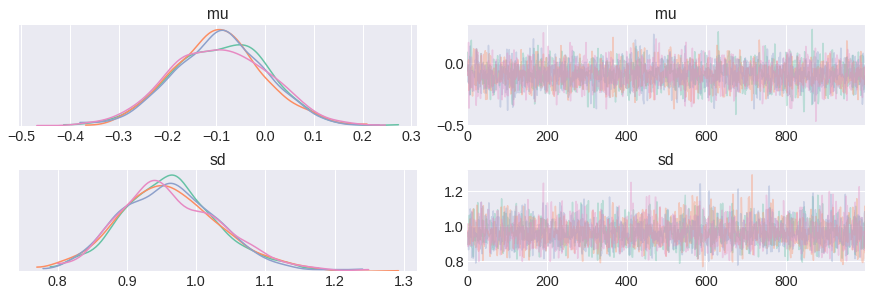

In [28]:
pm.traceplot(trace);

Можно смотреть также на метрику R-hat, которая называется также метрикой Gelman-Rubin

In [29]:
pm.rhat(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 1.004
    sd       float64 1.002

Можно посмотреть также на `forestplot` --- интервалы по каждой из 4-х марковских цепей

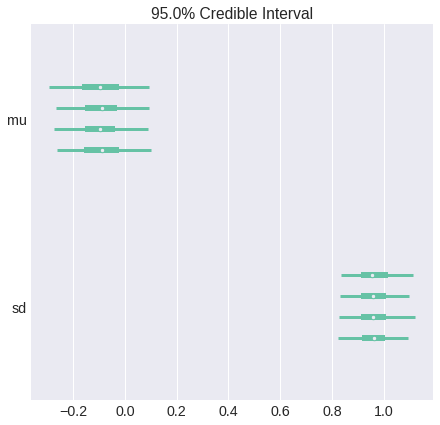

In [30]:
pm.forestplot(trace, linewidth=3, credible_interval=0.95);

Наконец, можно извлечь полезные свойства апостериорного распределения

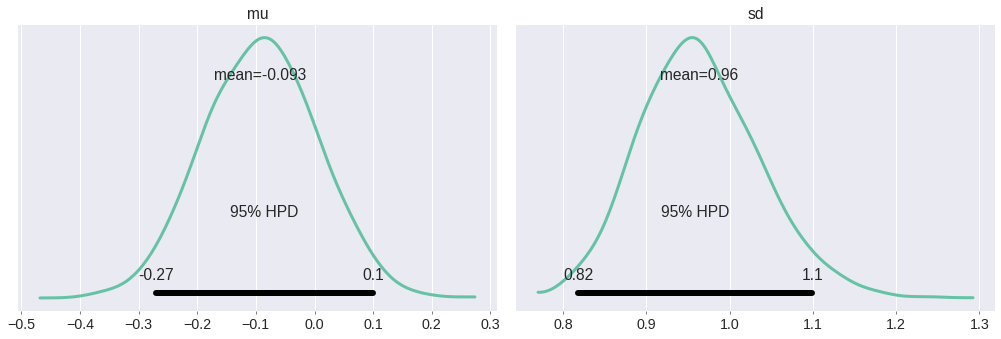

In [31]:
pm.plot_posterior(trace, linewidth=3, credible_interval=0.95);

Энергетический график

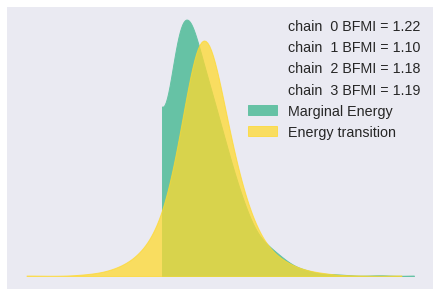

In [32]:
pm.energyplot(trace);

Список методов

In [33]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'Slice']

Широко используются еще методы `Metropolis` и `Slice`, но для большинства непрерывных моделей часто эффективнее `NUTS`. Методы можно поменять с помощью `step`.

In [34]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    x = pm.Normal('x', mu=mu, sigma=1, observed=sample)
    
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:00<00:00, 10886.81draws/s]
The number of effective samples is smaller than 25% for some parameters.


Для разных параметров можно использовать разные методы семплирования

In [35]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.HalfNormal('sd', sigma=1)
    x = pm.Normal('x', mu=mu, sigma=sd, observed=sample)
    
    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    trace = pm.sample(10000, step=[step1, step2], cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:17<00:00, 2357.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


## Вариационный вывод

Вариационный байесовский вывод производится с помощью функции `pm.fit()`.
По умолчанию эта функция пытается автоматически назначить сэмплер и инициализацию.


In [36]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.HalfNormal('sd', sigma=1)
    x = pm.Normal('x', mu=mu, sigma=sd, observed=sample)
    
    approx = pm.fit()

Average Loss = 143.59: 100%|██████████| 10000/10000 [00:02<00:00, 4158.73it/s]
Finished [100%]: Average Loss = 143.57


Он возвращает аппроксимацию апостериорного распределения, из которого можно, например, производить семплирование

In [37]:
approx.sample(10000)['mu']

array([-0.14844985,  0.10573228, -0.16930624, ..., -0.2296718 ,
       -0.19970605, -0.02393066])

<Figure size 432x288 with 0 Axes>

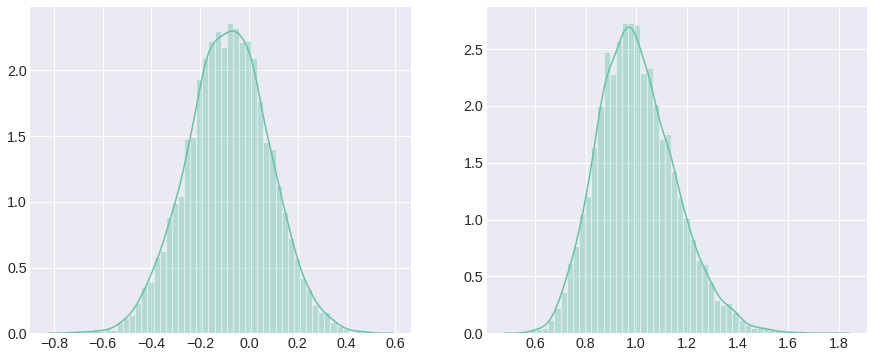

In [38]:
plt.figure()
trace = approx.sample(10000)
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.distplot(trace['mu']);
plt.subplot(122)
sns.distplot(trace['sd']);

Можно указывать различные методы для аппроксимаций

In [39]:
w = pm.floatX([.2, .8])
mu = pm.floatX([-.3, .5])
sd = pm.floatX([.1, .1])
with pm.Model() as model:
    pm.NormalMixture('x', w=w, mu=mu, sigma=sd)
    approx = pm.fit(method=pm.SVGD(n_particles=200, jitter=1.))

100%|██████████| 10000/10000 [00:56<00:00, 178.02it/s]


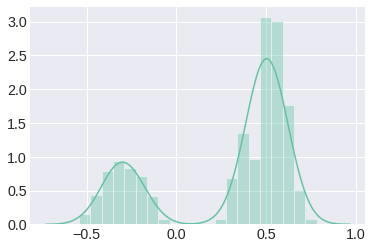

In [40]:
plt.figure()
trace = approx.sample(10000)
sns.distplot(trace['x']);

## Апостериорное предиктивное семплирование

Зададим модель

In [41]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.HalfNormal('sd', sigma=1)
    x = pm.Normal('x', mu=mu, sigma=sd, observed=sample)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2764.37draws/s]
The acceptance probability does not match the target. It is 0.8900441310508947, but should be close to 0.8. Try to increase the number of tuning steps.


С помощью проведенного семпла параметров функция `sample_posterior_predictive` может провести семплирование по предиктивному распределению данных

In [42]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 1260.46it/s]


Результат имеет размерность (количество семплов, размер исходной выборки). Переменную `trace` по функциональности можно понимать как байесовскую оценку параметров. Имея ее, мы можем для каждого наблюдения исходной выборки вычислить его предиктивное распределение

In [43]:
post_pred['x'].shape

(500, 100)

Сравним средние

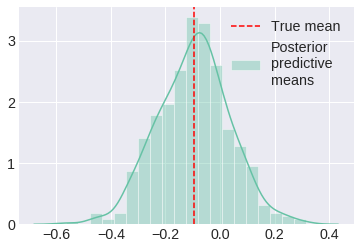

In [44]:
fig, ax = plt.subplots()
sns.distplot(post_pred['x'].mean(axis=1), label='Posterior\npredictive\nmeans', ax=ax)
ax.axvline(sample.mean(), ls='--', color='r', label='True mean')
ax.legend();

Подробнее эту функциональность изучим в следующий раз, когда будем рассматривать различные модели данных